## Data Storytelling

We can use visualization to help break down the complex into simpler diagrams for explanation. This is also helpful for showing correctness. For example, when you do outlier removal you people tend to go feature by feature and look at standard deviation from the mean and remove observations that way. This can be erroneous in data sets containing multiple features and correlations between those features. Mahalanobis distance is a measure of the distance between a point and a distribution. It is a multivariate distance metric that accounts for the correlations between different variables in the dataset. Unlike the Euclidean distance, which treats all dimensions equally and assumes they are orthogonal, the Mahalanobis distance considers the underlying data distribution and scales the distances accordingly. We can show the usefulness of this and explain it succinctly using the following visualization. 

First we set up some functions for calculating standard deviations, eigenvectors, eigenvalues, and ellipses based on the data. 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh
import math
from scipy.stats.distributions import chi2
from scipy import stats
import seaborn as sns
#%matplotlib inline

class sigma_ellipse_plot:

    def __init__(self, df=None, target='setosa', target_header='species', feature1='sepal_length', feature2='petal_width', std_devs=[1, 2, 3]):

        self.data = df
        self.target = target
        self.feature1 = feature1
        self.feature2 = feature2
        self.target_header = target_header
        self.std_devs=std_devs
        self.largest_eigenvalue = None
        self.largest_eigenvector = None
        self.smallest_eigenvalue = None
        self.smallest_eigenvector = None
        self.angle = None
        self.mean = None
        self.r_ellipses = None
        self.mu_X = None
        self.mu_Y = None
        self.chisquare_val = None

    def get_data(self):

        self.data = self.data[self.data[self.target_header] == self.target].drop(self.target_header, axis =1)[[self.feature1, self.feature2]]

        return

    def get_eigens(self):

        covariance_matrix = self.data.cov()
        eigenvalues, eigenvectors = eigh(covariance_matrix)

        self.largest_eigenvector = eigenvectors[np.argmax(eigenvalues)]
        self.largest_eigenvalue = np.max(eigenvalues)
        self.smallest_eigenvector = eigenvectors[np.argmin(eigenvalues)]
        self.smallest_eigenvalue = np.min(eigenvalues)

        return

    def get_angle(self):

        self.angle = math.atan2(self.largest_eigenvector[1], self.largest_eigenvector[0])

        return

    def shift_angle(self):

        if self.angle < 0:
            self.angle = self.angle + 2*math.pi

        return

    def get_mean(self):

        self.mean = self.data.mean()

        return

    def get_chisquare_vals(self):

        self.chisquare_val = []
        for i in range(0, len(self.std_devs)):
            percent_covered = stats.norm.cdf(self.std_devs[i]) - stats.norm.cdf(self.std_devs[i] * -1)
            self.chisquare_val.append((chi2.ppf(percent_covered, df=2))**0.5)

        return self.chisquare_val

    def get_ellipses(self):

        chisquare_val = self.get_chisquare_vals()

        self.r_ellipses = []
        for i in range(0, len(self.std_devs)):
            theta_grid = np.linspace(0,2*math.pi, 100)
            phi = self.angle
            self.mu_X = self.mean[0]
            self.mu_Y = self.mean[1]
            a = chisquare_val[i] * math.sqrt(self.largest_eigenvalue)
            b = chisquare_val[i] * math.sqrt(self.smallest_eigenvalue)

            ellipse_x_r = a * np.cos(theta_grid)
            ellipse_y_r = b * np.sin(theta_grid)

            R = [[math.cos(phi), math.sin(phi)], [-math.sin(phi), math.cos(phi)]]

            ellipses = np.array([ellipse_x_r, ellipse_y_r])

            r_ellipse = ellipses.T.dot(R).T

            self.r_ellipses.append(r_ellipse)

        return
    
    def get_labels(self, special_phrase=None):

        labels = []
        for i in range(0, len(self.std_devs)):

            if special_phrase is None:
                label = str(self.std_devs[i]) + " std. dev. from mean"
                labels.append(label)
            else: 
                label = special_phrase + str(self.std_devs[i]) + " std. dev. from mean"
                labels.append(label)

        return labels

    def pipeline(self):

        self.get_data()
        self.get_eigens()
        self.get_angle()
        self.shift_angle()
        self.get_mean()
        self.get_ellipses()

        return self.data, self.r_ellipses, self.mu_X, self.mu_Y

We then set up some code to calculate the mahalanobis distances

In [11]:
def mahalanobis_calculator(observations):
    """
    Calls a matrix of observations and calculates mahalanobis distances
    observations input has features in its columns and each instance in its rows
    if the input is n by k (n rows and k features) the output will be
    n by 1
    """
    # calculate mean of each feature
    observations_mean = np.mean(observations, axis=0)
    # calculate covaraince matrix; it will be k by k
    # in case of this problem: 4 by 4
    cov_mat = np.cov(observations.T)
    # inverse of covariance matrix
    cov_mat_inv = np.linalg.inv(cov_mat)
    # list of distances
    mahal_distances = []
    # loop through rows
    for i in range(observations.shape[0]):
        # first part of the (Mahalanobis distance)**2 formula
        temp = np.dot(observations[i] - observations_mean, cov_mat_inv)
        # second part of the (Mahalanobis distance)**2 formula
        temp2 = np.dot(temp, (observations[i] - observations_mean).T)
        # append the sqrt of D**2 to the list
        mahal_distances.append(math.sqrt(temp2))
    return mahal_distances

Read in the data which is the `iris.csv` located in the GitHub for your download. We are going to specifically look at two features for comparison and analysis, `sepal_length` and `petal_width`.

In [12]:
df = pd.read_csv('iris.csv')
feature1 = 'sepal_length'
feature2 = 'petal_width'

We are going to run our functions from above to grab important values needed for the plots.

In [29]:
setosa_ellipses_obj = sigma_ellipse_plot(df=df, target='setosa', feature1=feature1, feature2=feature2)
setosa_df, setosa_ellipses, setosa_mu_X, setosa_mu_Y = setosa_ellipses_obj.pipeline()
setosa_plot_labels = setosa_ellipses_obj.get_labels()
mahal_distances = mahalanobis_calculator(setosa_df.to_numpy())
outlier_index = mahal_distances.index(max(mahal_distances))

Now, if we are simply going to look at the mean and standard deviation of each feature individually we could then draw some circles around the data and see where the observations fell and remove outliers based on that alone. In this case we could use the below code to do that. 

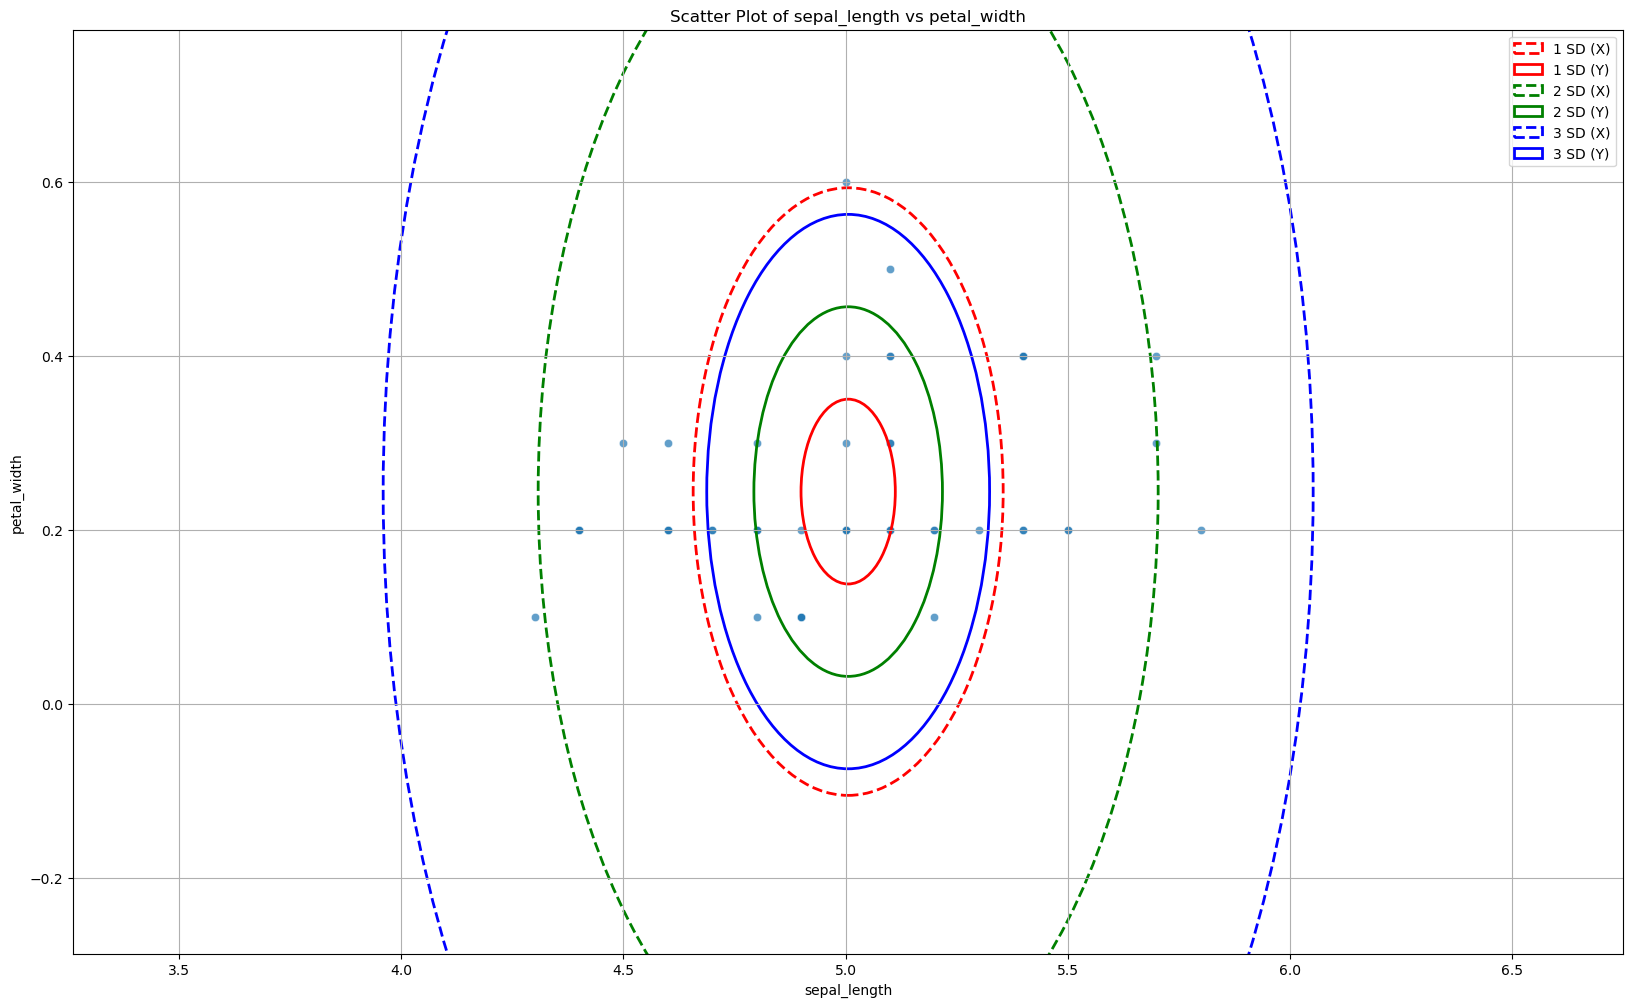

In [30]:
x = setosa_df[feature1]
y = setosa_df[feature2]

mean_x = np.mean(x)
mean_y = np.mean(y)
std_x = np.std(x)
std_y = np.std(y)

plt.figure(figsize=(20, 12))
sns.scatterplot(x=x, y=y, alpha=0.7)

circle1 = plt.Circle((mean_x, mean_y), std_x, color='r', fill=False, linestyle='--', linewidth=2, label='1 SD (X)')
circle2 = plt.Circle((mean_x, mean_y), std_y, color='r', fill=False, linestyle='-', linewidth=2, label='1 SD (Y)')

circle3 = plt.Circle((mean_x, mean_y), 2*std_x, color='g', fill=False, linestyle='--', linewidth=2, label='2 SD (X)')
circle4 = plt.Circle((mean_x, mean_y), 2*std_y, color='g', fill=False, linestyle='-', linewidth=2, label='2 SD (Y)')

circle5 = plt.Circle((mean_x, mean_y), 3*std_x, color='b', fill=False, linestyle='--', linewidth=2, label='3 SD (X)')
circle6 = plt.Circle((mean_x, mean_y), 3*std_y, color='b', fill=False, linestyle='-', linewidth=2, label='3 SD (Y)')

plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.gca().add_patch(circle3)
plt.gca().add_patch(circle4)
plt.gca().add_patch(circle5)
plt.gca().add_patch(circle6)

plt.xlim(mean_x - 5*std_x, mean_x + 5*std_x)  # Set limits to 3 standard deviations around the mean
plt.ylim(mean_y - 5*std_y, mean_y + 5*std_y)

plt.title('Scatter Plot of ' + feature1 + ' vs ' + feature2)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.legend()
plt.grid(True)
plt.show()

If you notice, all of the data is firmly between the third standard deviation for the `sepal_length` but yet outside of it for `petal_width`. We can see it because we are plotting and we are only taking into account these 2 features individually out of the four in the data set. 

Compare this now to the Mahalanobis distance, where we have already accounted for the underlying distribution and the correlations of the features. We now plot.

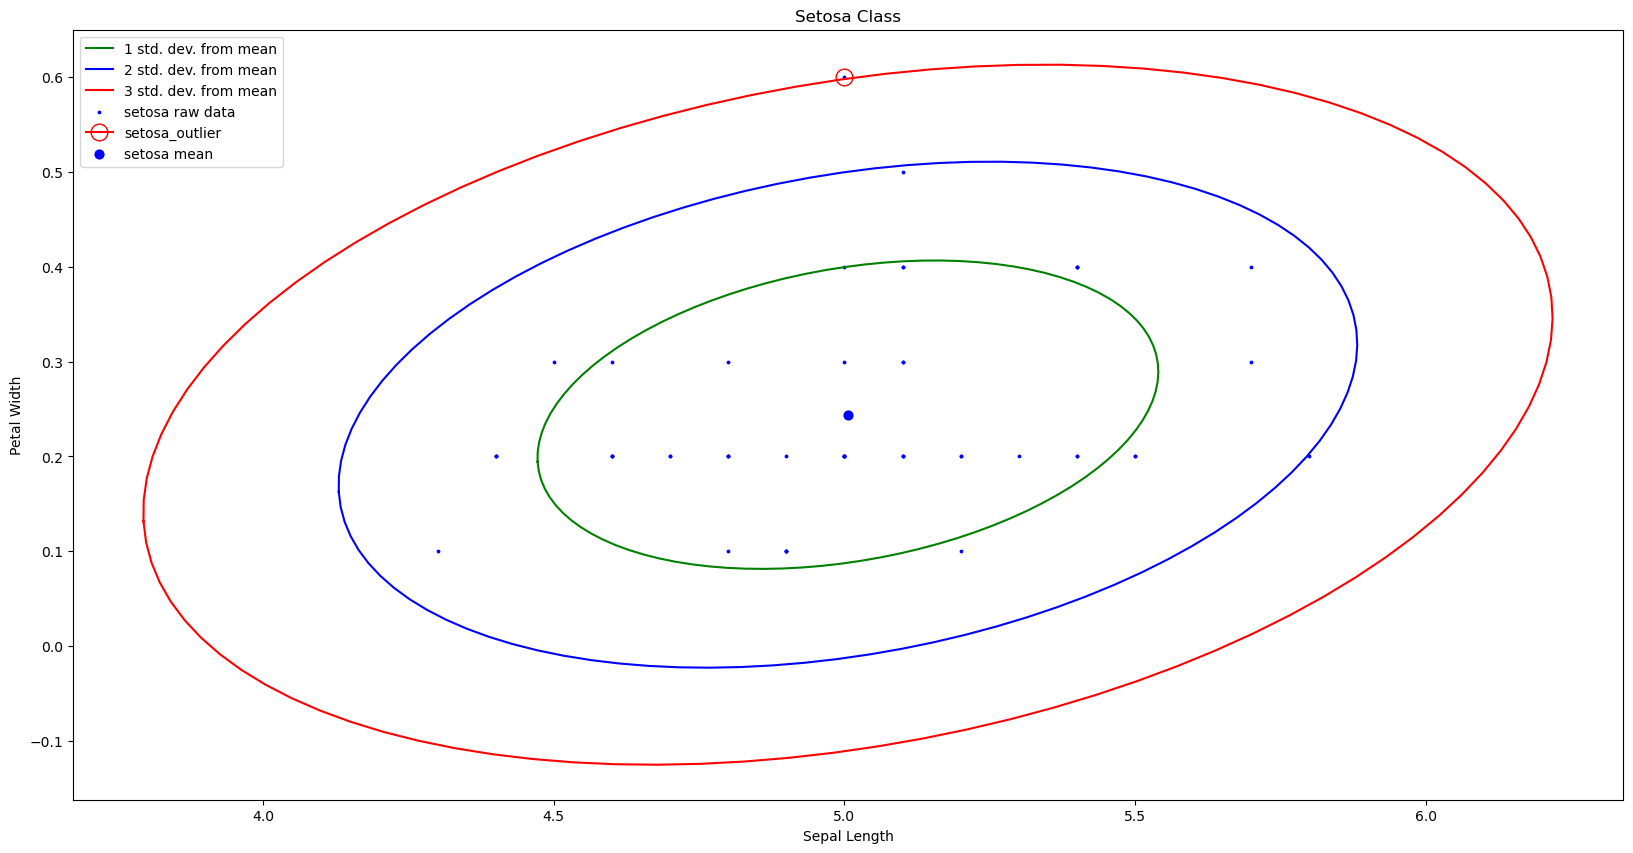

In [5]:
plt.figure(figsize=(20,10))

colors_for_plot = ['g', 'b', 'r']
for i in range(0, len(setosa_ellipses)):
    plt.plot(setosa_ellipses[i][0] + setosa_mu_X, setosa_ellipses[i][1] + setosa_mu_Y, colors_for_plot[i], label= setosa_plot_labels[i])

plt.scatter(setosa_df[feature1], setosa_df[feature2], c='blue', s=3, label='setosa raw data')

plt.plot(setosa_df[feature1][outlier_index], setosa_df[feature2][outlier_index], marker='o', color='r', markersize=12, fillstyle='none', label='setosa_outlier')

plt.scatter(setosa_mu_X, setosa_mu_Y, c='blue', s=40, label = 'setosa mean')

plt.xlabel('Sepal Length', fontsize=10)
plt.ylabel('Petal Width', fontsize=10)
plt.title('Setosa Class')
plt.legend()
plt.show()

The 1 point that lies outside of the third standard deviation from the mean of the data set could be considered the outlier. This is in a two dimensional space so that we can plot a higher dimension into a lower dimension. However, this can be done at magnitudes greater and the concept still applies. 